### 1. Importing the Necessary Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize']=(13,7)
sns.set_style('darkgrid')


from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

/home/student/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### 2. Reading the Data

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

### 3. Data Exploration 

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


#### Finding the Missing Values

In [5]:
def missing_percentage(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = total/len(df)*100
    new = pd.concat([total,percent],axis=1,keys=['Total','Percent'])
    return new[new['Percent']!=0]

In [6]:
missing_percentage(train)

,Total,Percent
Cabin,687,77.104377
Age,177,19.865320
Embarked,2,0.224467


In [7]:
missing_percentage(test)

,Total,Percent
Cabin,327,78.229665
Age,86,20.574163
Fare,1,0.239234


In [8]:
train[train['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [9]:
# Correlatin of Features with target variable
corr_features = abs(train.corr()['Survived']).sort_values(ascending=False)[1:]
corr_features

Pclass         0.338481
Fare           0.257307
Parch          0.081629
Age            0.077221
SibSp          0.035322
PassengerId    0.005007
Name: Survived, dtype: float64

### 4. Data Visualisation

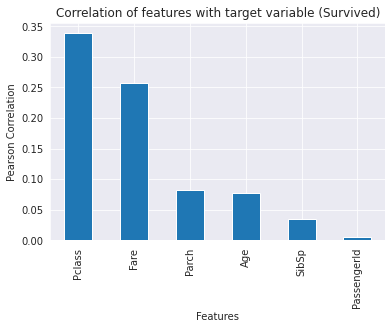

In [10]:
(abs(train.corr()['Survived']).sort_values(ascending=False)[1:]).plot(kind='bar')
plt.title('Correlation of features with target variable (Survived)')
plt.xlabel('Features')
plt.ylabel('Pearson Correlation');

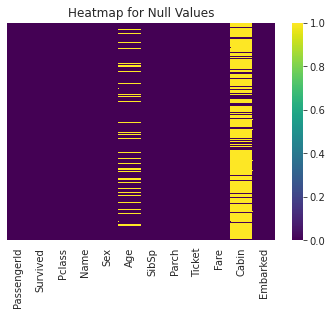

In [11]:
sns.heatmap(train.isnull(),yticklabels=False,cmap='viridis')
plt.title('Heatmap for Null Values');

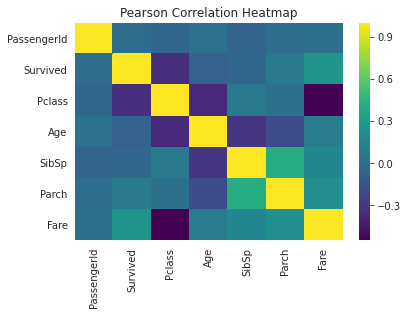

In [12]:
sns.heatmap(train.corr(),cmap='viridis',cbar=True)
plt.title('Pearson Correlation Heatmap');

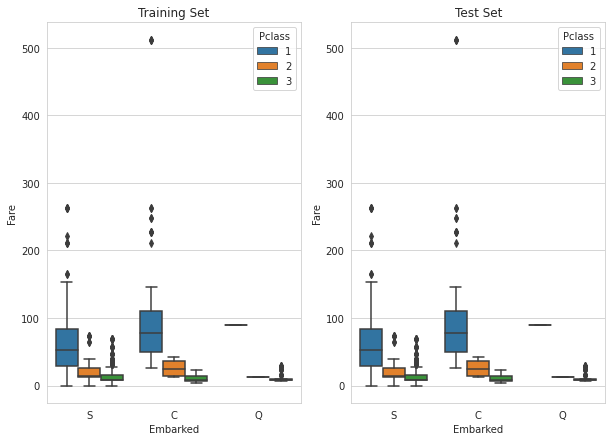

In [13]:
%matplotlib inline
sns.set_style('whitegrid')
fig , (ax1,ax2) = plt.subplots(1,2,figsize=(10,7))
ax1.set_title('Training Set')
sns.boxplot(x='Embarked',y='Fare',hue='Pclass',data=train,ax=ax1)
ax2.set_title('Test Set')
sns.boxplot(x='Embarked',y='Fare',hue='Pclass',data=train,ax=ax2)

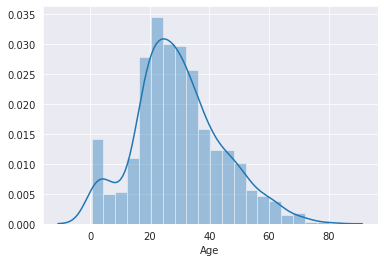

In [14]:
sns.set_style('darkgrid')
sns.distplot(train['Age'].dropna())

### 5. Imputing missing values

In [15]:
# Filling the Embarked column
train['Embarked'].fillna('C',inplace=True)

survivers = train.Survived
train.drop('Survived',axis=1,inplace=True)
all_data = pd.concat([train,test],axis=0)
all_data['Cabin'].fillna('N',inplace=True)

all_data['Cabin'] = [i[0] for i in all_data['Cabin']]

In [16]:
missing_percentage(all_data)

,Total,Percent
Age,263,20.091673
Fare,1,0.076394


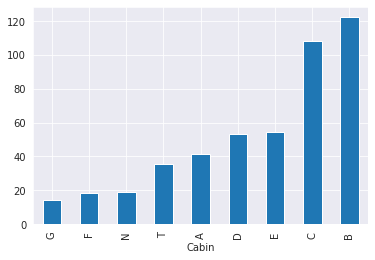

In [17]:
all_data.groupby('Cabin')['Fare'].mean().sort_values(ascending=True).plot(kind='bar')

In [18]:
def cabin_estimator(i):
    a = 0
    if i<16:
        a = "G"
    elif i>=16 and i<27:
        a = "F"
    elif i>=27 and i<38:
        a = "T"
    elif i>=38 and i<47:
        a = "A"
    elif i>= 47 and i<53:
        a = "E"
    elif i>= 53 and i<54:
        a = "D"
    elif i>=54 and i<116:
        a = 'C'
    else:
        a = "B"
    return a

with_N = all_data[all_data['Cabin']=='N']
without_N = all_data[all_data['Cabin']!= 'N']

with_N['Cabin'] = with_N.Fare.apply(lambda x: cabin_estimator(x))

all_data = pd.concat([with_N,without_N],axis=0)
all_data.sort_values(by='PassengerId',inplace=True)

In [19]:
train = all_data.iloc[:891,:]
test = all_data.iloc[891:,:]
train['Survived'] = survivers

missing_value = test[(test['Pclass']==3)&
                     (test['Sex']=='male')&
                     (test['Embarked']=='S')]['Fare'].mean()
test['Fare'].fillna(missing_value,inplace=True)

In [20]:
survived_summary = train.groupby("Survived")
survived_summary.mean().reset_index()

,Survived,PassengerId,Pclass,Age,SibSp,Parch,Fare
0,0,447.016393,2.531876,30.626179,0.553734,0.329690,22.117887
1,1,444.368421,1.950292,28.343690,0.473684,0.464912,48.395408


In [21]:
survived_summary = train.groupby("Sex")
survived_summary.mean().reset_index()

,Sex,PassengerId,Pclass,Age,SibSp,Parch,Fare,Survived
0,female,431.028662,2.159236,27.915709,0.694268,0.649682,44.479818,0.742038
1,male,454.147314,2.389948,30.726645,0.429809,0.235702,25.523893,0.188908


In [22]:
train["title"] = [i.split('.')[0] for i in train.Name]
train['title'] = [i.split(',')[1] for i in train.title]

train.title = train.title.apply(lambda x: x.strip())
train['title'].unique()

test['title'] = [i.split('.')[0].split(',')[1].strip() for i in test['Name']]

In [23]:
def name_converter(name):
    result = ''
    if name in ['Master', 'Don', 'Rev', 'Dr',
       'Major', 'Lady', 'Sir', 'Col', 'Capt', 'the Countess',
       'Jonkheer','Dona']:
        result = 'rare'
    elif name in ['Ms', 'Mlle']:
        result = 'Mrs'
    elif name == 'Mme':
        result = 'Mr'
    else:
        result = name
    return result

train['title'] = train['title'].map(name_converter)
test['title'] = test['title'].map(name_converter)

train['family_size'] = train.SibSp + train.Parch+1
test['family_size'] = test.SibSp + test.Parch+1

### 5.1 Droping unnecessary columns

In [24]:
drops = ['Name','SibSp','Parch','PassengerId','Ticket']
train.drop(drops,axis=1,inplace=True)
test.drop(drops,axis=1,inplace=True)

categories = []
def categorical(df):
    for column in df.columns:
        if df[column].dtype == 'object':
            categories.append(column)
categorical(train)

train.drop('Survived',axis=1,inplace=True)

### 5.2 Onehot encoding the categorical features

In [25]:
total_data = pd.concat([train,test],axis=0)
onehot = pd.get_dummies(total_data[categories],drop_first=True)

total_data.drop(categories,axis=1,inplace=True)
total_onehot_data = pd.concat([total_data,onehot],axis=1)

pclass = pd.get_dummies(total_onehot_data['Pclass'],drop_first=True)
total_onehot_data.drop('Pclass',axis=1,inplace=True)

total_onehot_data = pd.concat([total_onehot_data,pclass],axis=1)
train = total_onehot_data.iloc[:891,:]
test = total_onehot_data.iloc[891:,:]

### 5.3 Imputing Age column with Random Forest

In [26]:
from sklearn.ensemble import RandomForestRegressor
def completing_age(df):
    temp_train = df.loc[df.Age.notnull()] 
    temp_test = df.loc[df.Age.isnull()]
    y = temp_train.Age.values 
    x = temp_train.loc[:, "Fare":].values
    rfr = RandomForestRegressor(n_estimators=15, n_jobs=-1)
    rfr.fit(x, y)
    predicted_age = rfr.predict(temp_test.loc[:, "Fare":])
    df.loc[df.Age.isnull(), "Age"] = predicted_age
    return df

train = completing_age(train)

test = completing_age(test)

### 6. Splitting the data into training and testing sets

In [27]:
X = train.values
y = survivers
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### 6.1 Standard Scaling the features

In [28]:
sc = StandardScaler()
X_train[:,0:3] =  sc.fit_transform(X_train[:,0:3])
X_test[:,0:3] = sc.fit_transform(X_test[:,0:3])

### 7. Developing Models

### 7.1 Logistic Regression

In [29]:
lr = LogisticRegression(solver='liblinear',random_state=0)
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.84      0.83      0.83       110
           1       0.73      0.75      0.74        69

    accuracy                           0.80       179
   macro avg       0.79      0.79      0.79       179
weighted avg       0.80      0.80      0.80       179



### 7.2 Logistic Regression with Grid Search (Hyperparameter Tuning)

In [30]:
C_vals = [0.2,0.3,0.4,0.5,0.6,0.9,1]
penalties = ['l1','l2']
param = {'penalty': penalties, 'C': C_vals}
grid = GridSearchCV(estimator=lr, 
                    param_grid = param,
                    scoring = 'accuracy',
                    n_jobs =-1,
                    cv = 5)
grid.fit(X_train,y_train)

lr_grid = grid.best_estimator_
lr_grid.fit(X_train,y_train)
y_pred = lr_grid.predict(X_test)

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.84      0.85      0.85       110
           1       0.76      0.74      0.75        69

    accuracy                           0.81       179
   macro avg       0.80      0.80      0.80       179
weighted avg       0.81      0.81      0.81       179



### 7.3 K-nearest neighbors with Grid Search

In [31]:
k_range = range(1,15)
weights_options=['uniform','distance']
param = {'n_neighbors':k_range, 'weights':weights_options}
grid = GridSearchCV(KNeighborsClassifier(), param,cv=5,verbose = False, n_jobs=-1)
## Fitting the model. 
grid.fit(X,y)

knn_grid = grid.best_estimator_
knn_grid.fit(X_train,y_train)
y_pred = knn_grid.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.84      0.89      0.86       110
           1       0.81      0.72      0.76        69

    accuracy                           0.83       179
   macro avg       0.82      0.81      0.81       179
weighted avg       0.83      0.83      0.82       179



### 7.4 Support Vector Machines with Grid Search

In [32]:
Cs = [0.001, 0.01, 0.1, 1,1.5]
gammas = [0.0001,0.001, 0.01]
param_grid = {'C': Cs, 'gamma' : gammas}
grid_search = GridSearchCV(SVC(kernel = 'rbf', probability=True), param_grid, verbose =0,cv=5)
grid_search.fit(X,y)

svm_grid = grid_search.best_estimator_
svm_grid.fit(X_train,y_train)
y_pred = svm_grid.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.84      0.81      0.82       110
           1       0.71      0.75      0.73        69

    accuracy                           0.79       179
   macro avg       0.78      0.78      0.78       179
weighted avg       0.79      0.79      0.79       179



### 7.5 Decision Tree with Grid Search

In [33]:
max_depth = range(1,15)
max_feature = [14,15,16,17,18]
criterion=["entropy", "gini"]

param = {'max_depth':max_depth, 
         'max_features':max_feature, 
         'criterion': criterion}
grid = GridSearchCV(DecisionTreeClassifier(), 
                    param_grid = param, 
                    verbose=2, 
                    cv=5,
                    n_jobs = -1)
grid.fit(X_train, y_train) 

dtree_grid = grid.best_estimator_
dtree_grid.fit(X_train,y_train)
y_pred = dtree_grid.predict(X_test)
print(classification_report(y_test,y_pred))

Fitting 5 folds for each of 140 candidates, totalling 700 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


              precision    recall  f1-score   support

           0       0.82      0.86      0.84       110
           1       0.76      0.70      0.73        69

    accuracy                           0.80       179
   macro avg       0.79      0.78      0.78       179
weighted avg       0.80      0.80      0.80       179



[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:    3.1s finished


### 7.6 Random Forest with Grid Search

In [34]:
n_estimators = [140,160,270]
max_depth = range(8,13)
criterions = ['gini', 'entropy']
parameters = {'n_estimators':n_estimators,
              'max_depth':max_depth,
              'criterion': criterions
              }
grid = GridSearchCV(estimator=RandomForestClassifier(max_features='auto'),
                                 param_grid=parameters,
                                 cv=5,
                                 n_jobs = -1)
grid.fit(X,y) 

rnf_grid = grid.best_estimator_
rnf_grid.fit(X_train,y_train)
y_pred = rnf_grid.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.81      0.86      0.84       110
           1       0.76      0.68      0.72        69

    accuracy                           0.79       179
   macro avg       0.79      0.77      0.78       179
weighted avg       0.79      0.79      0.79       179



#### 7.6.1 Feature Importance of Random Forest

In [35]:
feature_importances = pd.DataFrame(rnf_grid.feature_importances_,
                                   index=train.columns,
                                    columns=['importance'])
feature_importances.sort_values(by='importance', ascending=False)

,importance
Age,0.195186
Fare,0.183251
title_Mr,0.158486
Sex_male,0.132287
family_size,0.083158
3,0.058796
title_Mrs,0.033520
Embarked_S,0.024397
Cabin_G,0.023216
2,0.020358


### 7.7 XGBoost

In [36]:
XGBClassifier = XGBClassifier()
XGBClassifier.fit(X_train, y_train)

y_pred = XGBClassifier.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.82      0.90      0.86       110
           1       0.81      0.70      0.75        69

    accuracy                           0.82       179
   macro avg       0.82      0.80      0.81       179
weighted avg       0.82      0.82      0.82       179



### 7.8 Voting Classifer (Hard Voting)

In [37]:
voting_classifier = VotingClassifier(estimators=[
    ('lr_grid', lr_grid),
    ('svc', svm_grid),
    ('random_forest', rnf_grid),
    ('decision_tree_grid',dtree_grid),
    ('knn_classifier', knn_grid),
    ('XGB_Classifier', XGBClassifier)],voting='hard')
voting_classifier = voting_classifier.fit(X_train,y_train)

y_pred = voting_classifier.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.82      0.89      0.86       110
           1       0.80      0.70      0.74        69

    accuracy                           0.82       179
   macro avg       0.81      0.79      0.80       179
weighted avg       0.81      0.82      0.81       179



 As we have seen, the voting classifier merges all the models given. It is the best model compared to every other one. The f1-score achieved for this voting classifier 0.81